シミュレーションデータでGLM

In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf

課題設定：
- 脳のどこの領域が顔を処理するのに関わっているかを特定する
- 顔の画像を見せた時に、脳のどの領域が活発化するかを調べる
  - trial : 1つの顔の画像を見せる実験
- 5 trialsでどのようになるかみてみる
- はじめに、facesを、タイムポイントの時系列ベクトルとしてして定義する
  - 全単位時間：200
  - 全トライアル回数：5

![faces](../images/glm/faces.png)

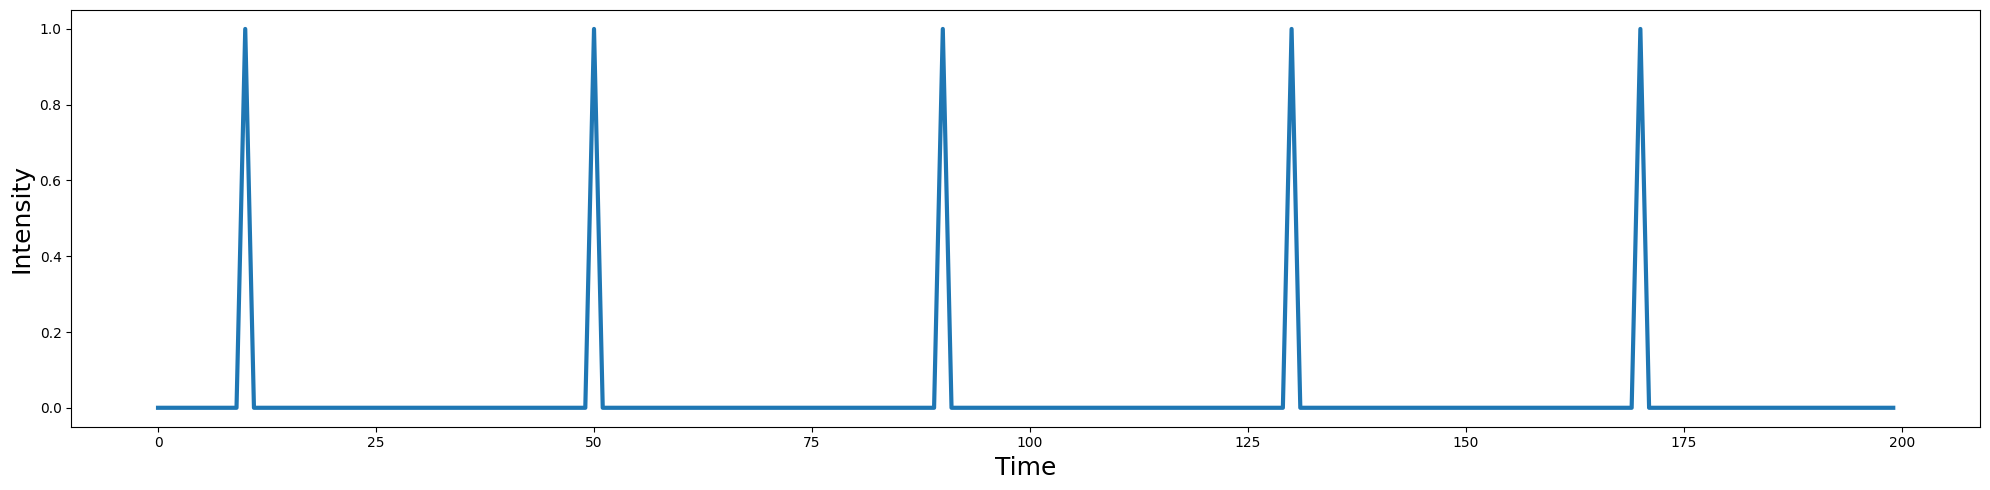

In [3]:
n_tr = 200 # 時系列のボリューム数
n_trial = 5 # 試行数
face = np.zeros(n_tr) # 時系列データとしてfacesを初期化

# 10 時間ボリューム以降、trialがあるところでfacesを1にする
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1

def plot_timeseries(data, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    
    # ラベルがあるかをみる
    if labels is not None:
        # さらに、ラベルの数とデータの列数が一致しているかをみる
        if len(labels) != data.shape[1]:
            # 一致していない場合はエラーを出す
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)
    
plot_timeseries(face)


- でも画像刺激だったら、何にでも反応するのでは？
  - 顔特有に反応している領域を見つけるには、もう一つ比較する条件をつける必要がある。
    - 例：輝度もカラーも同じ、でもフーリエ変換→位相だけランダムにする（phase_scarmbled）→逆フーリエ変換、をした画像を見せる
    - 視覚の低次元の性質・プロパティーは統制できるかもしれない

![phase](../images/glm/phase_scrambled.png)

- 一方で、高次元の視覚的性質はどうか？
  - 顔とはオブジェクトであり、これでも統制したい。全てのオブジェクトに反応するのではなく、顔だけに反応する領域を見つけたい。
  - 

![objects](../images/glm/objects.png)

- 2つの条件は、異なるタイプのビジュアルコントロール（統制）をする。
- ここではシンプルに、視覚の低次元の性質も統制しつつ、オブジェクトでもあるものを見せて統制したい。
  - 統制をコントラストと言ったりもする。
  - fMRIはrelativeなので、contrastのような引き算型の解析は適している。

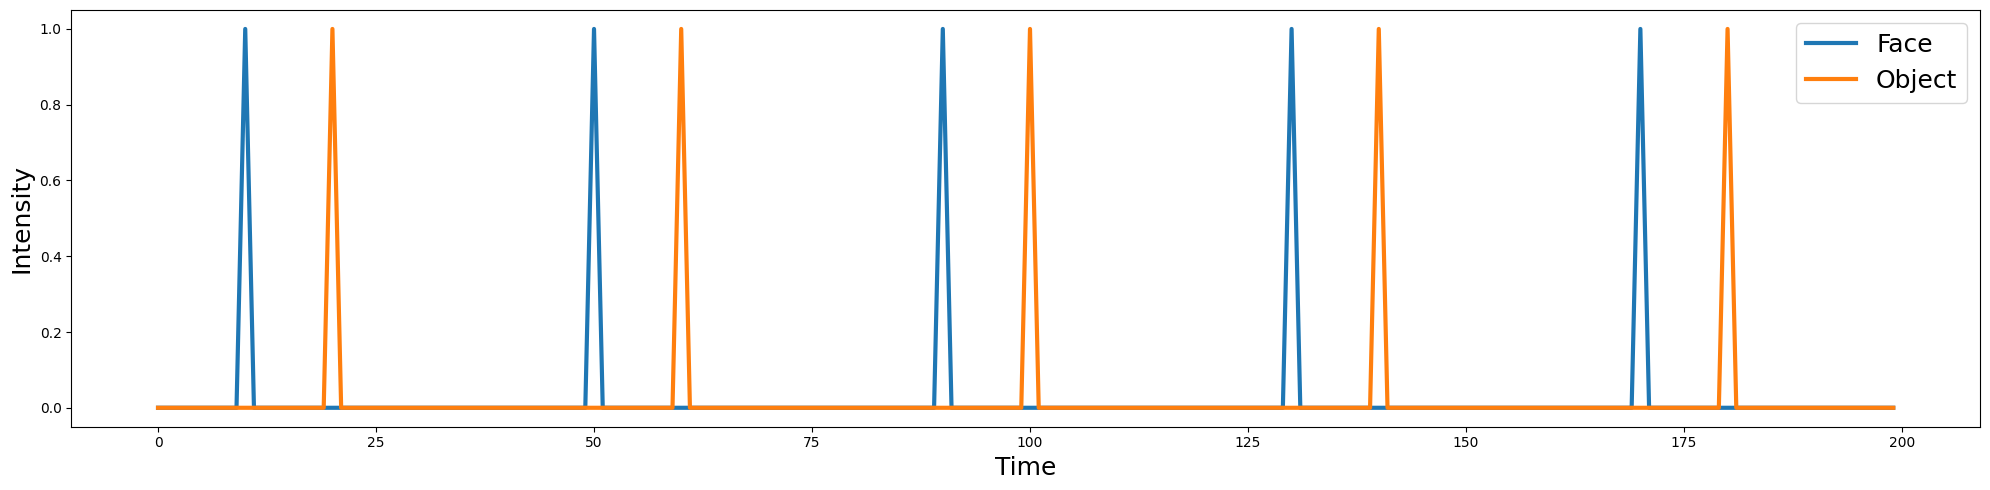

In [4]:
# FaceとObjectを見せるときの時系列データを作成

n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

シミュレーションとして、顔を見ている時は、２倍の反応があるとしてみる

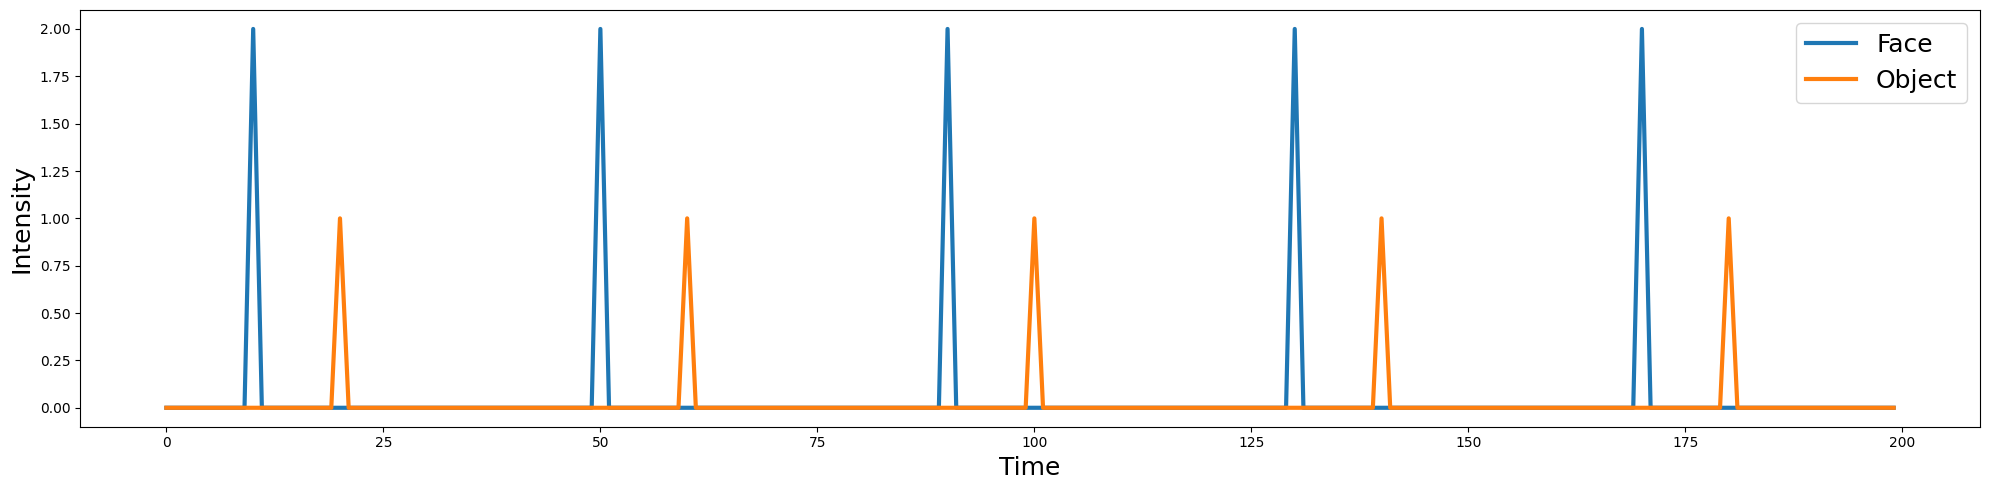

In [5]:
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

刺激から血液動態への変換には時間がかかる。→ 時間変化のモデルとして、double-gamma HRFを使い、上のと畳み込みしてみる

まずは、畳み込み前のもの。

Text(0.5, 0, 'Time')

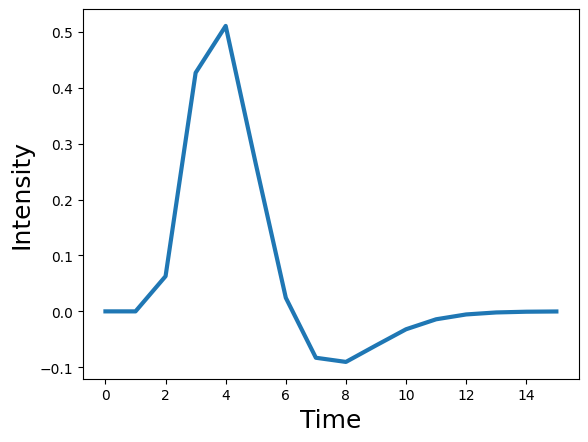

In [6]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

畳み込みをしてみると、

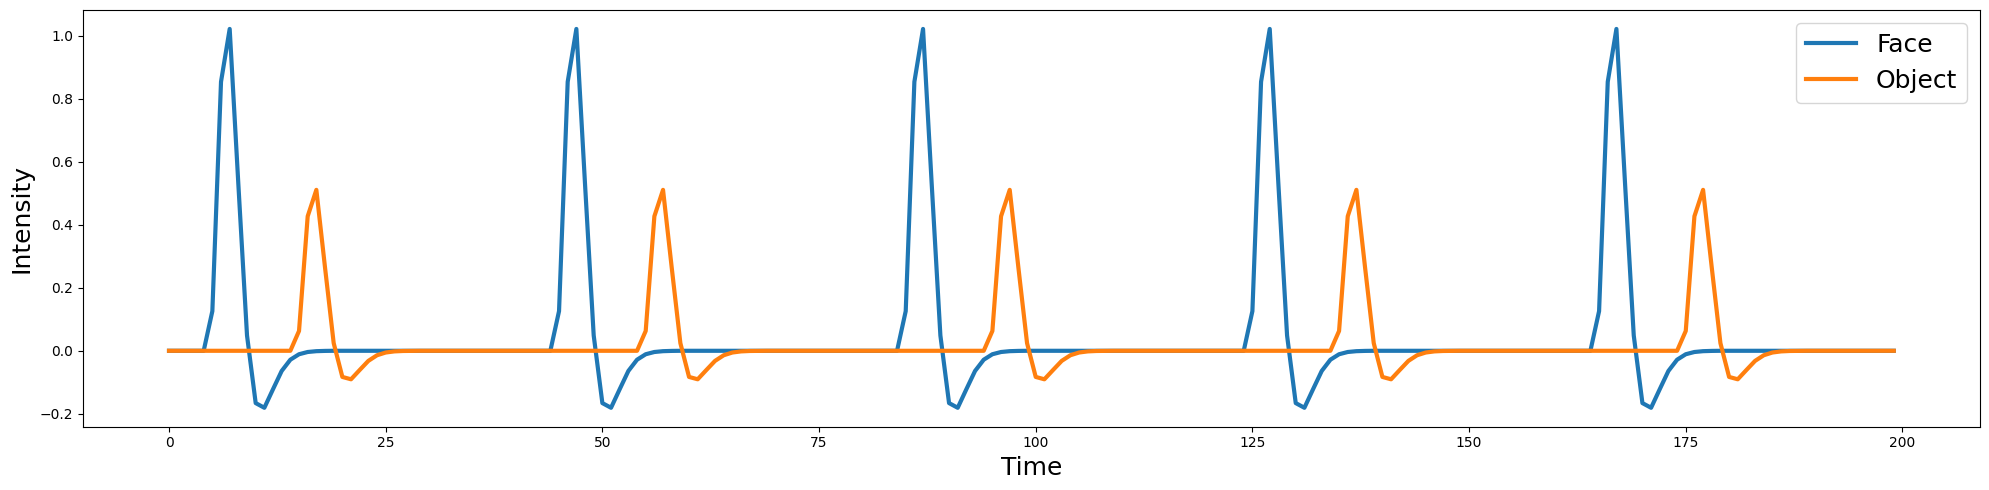

In [7]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(voxel_conv, labels=['Face', 'Object'])

リアルデータに近づけるためにノイズを加えて、

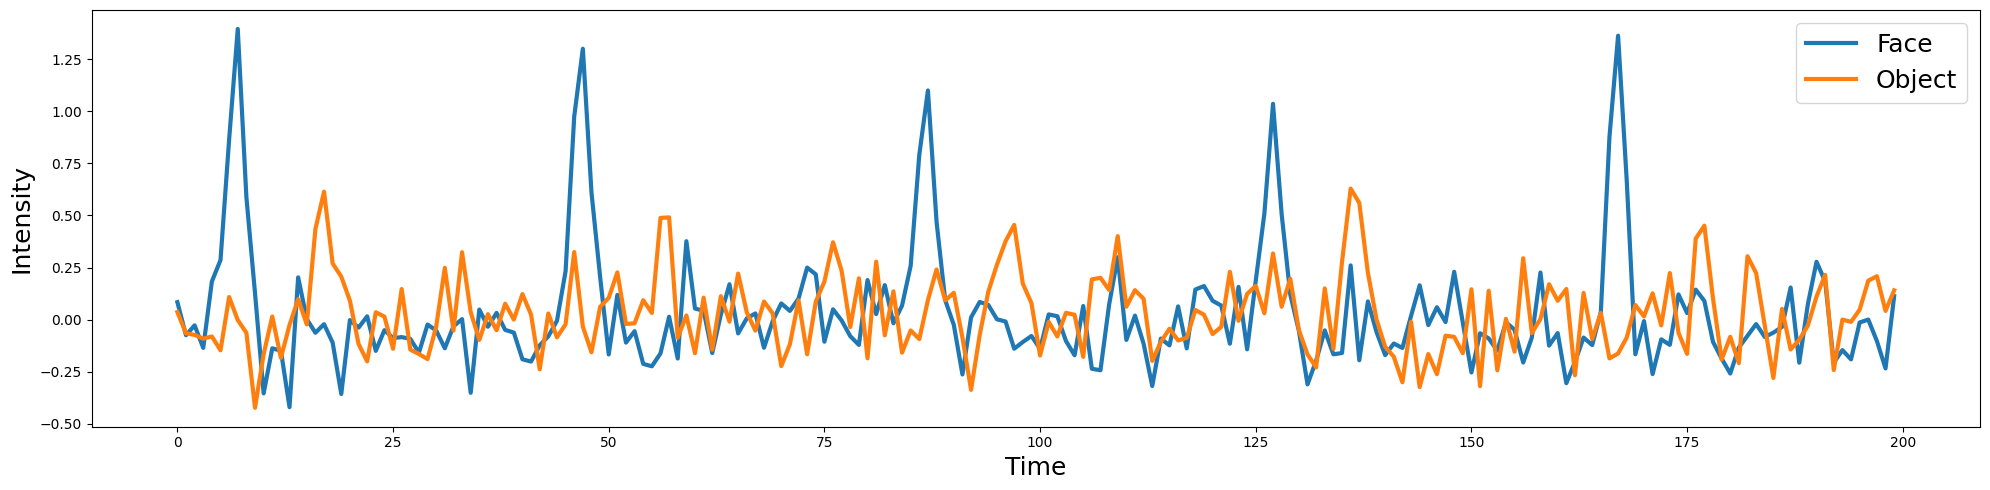

In [8]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise, labels=['Face', 'Object'])

実際には、顔とオブジェクトどちらの信号かはわからない（時間的に見れば分かるものではある）から、一つの系列にしてリアルっぽくすると、

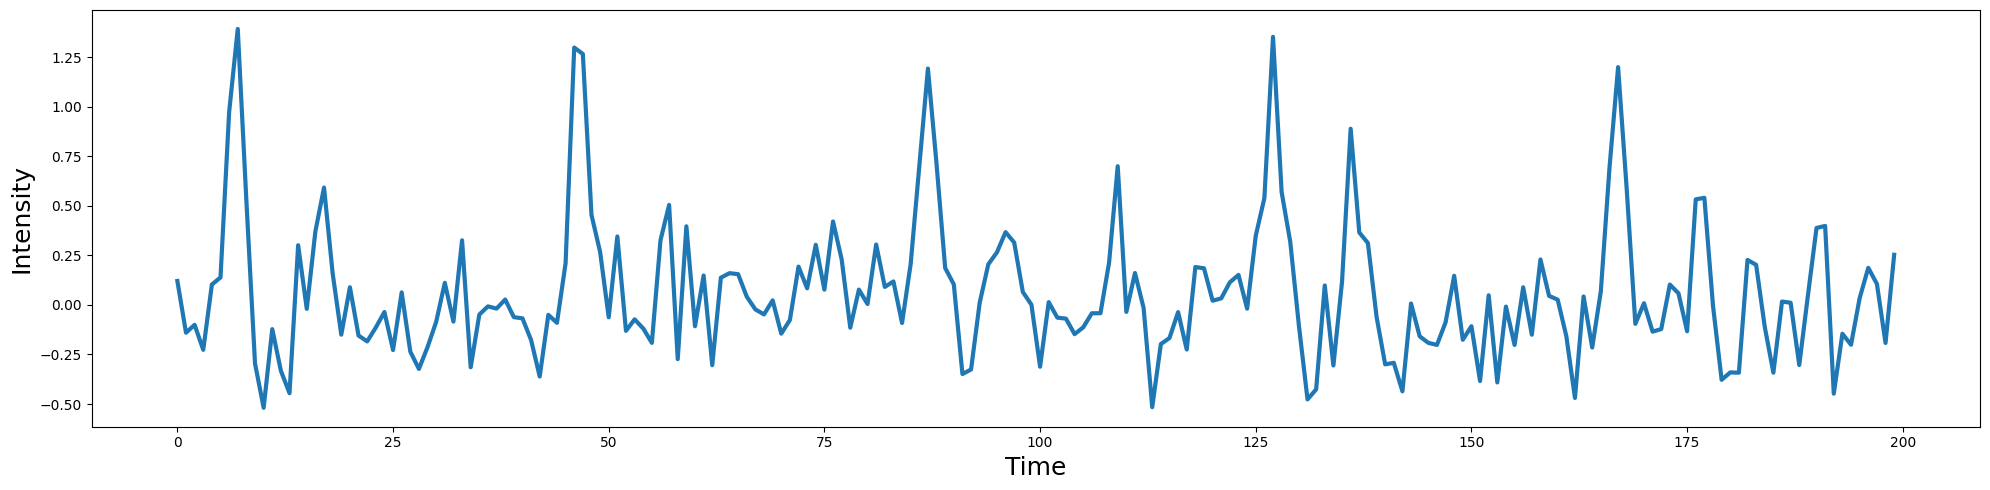

In [9]:
Y = voxel_conv_noise.sum(axis=1)

plot_timeseries(Y)

# 計画行列の作成

- ボクセルの反応を予測してみる。
  - X : HRFと刺激の畳み込み
    -  刺激は、顔(オレンジ)とオブジェクト（緑）の２つの系列
    -  切片あり（青）
  - Y : さっき作ったノイズまみれのデータ
- 時系列情報は無視する。

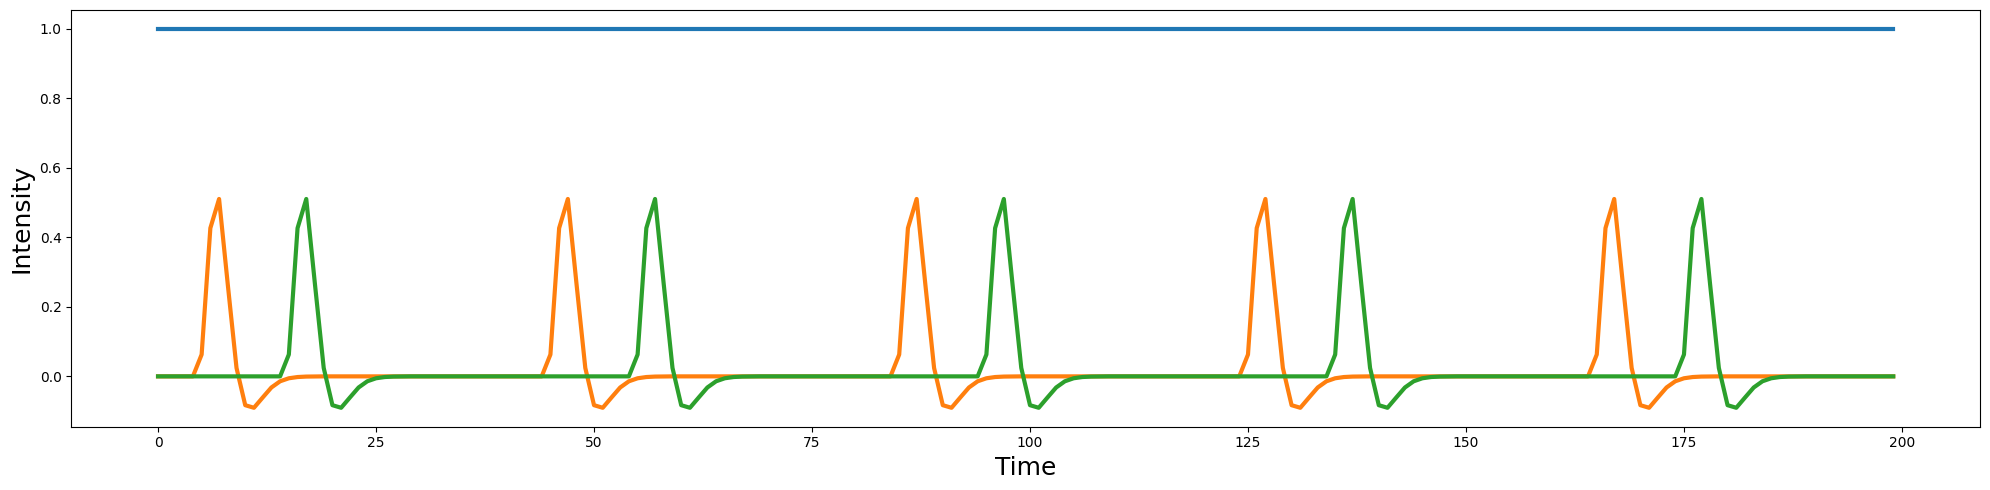

In [10]:
# Design Matrix
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
intercept = np.ones(n_tr)
X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

plot_timeseries(X)

つまり回帰式は、

$$Voxel = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects + \epsilon$$

より回帰式がわかりやすいようにプロットを作ると、

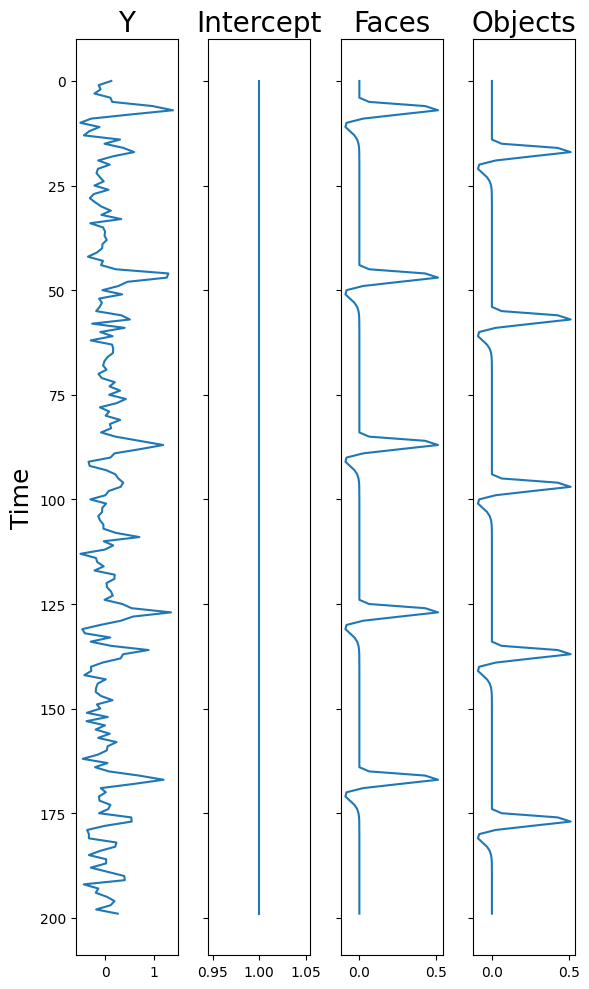

In [11]:
f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()

# GLMのパラメータ推定

OLS推定値（正規分布の最尤推定値）で求める
$$\hat{\beta} = (X^T X)^{-1}X^TY$$

beta Faces - beta Objects: 1.3


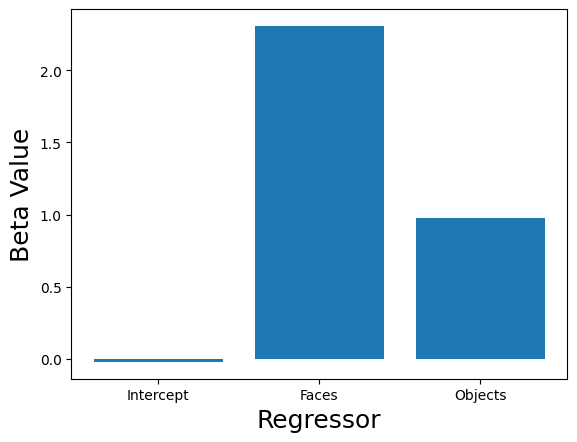

In [12]:
def ols_estimator(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

beta = ols_estimator(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'beta Faces - beta Objects: {beta[1]-beta[2]:.2}')

予実プロットと残差プロットを見てみる

Text(0.5, 1.0, 'Residual')

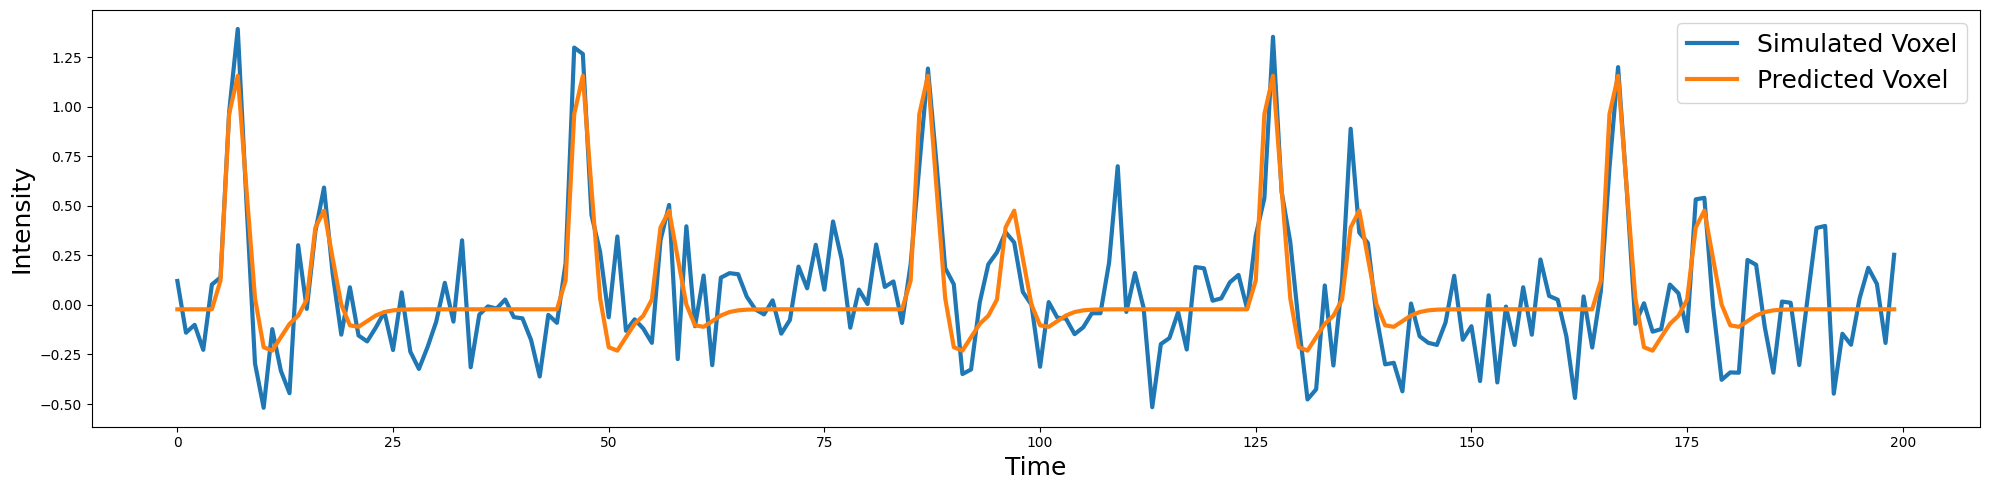

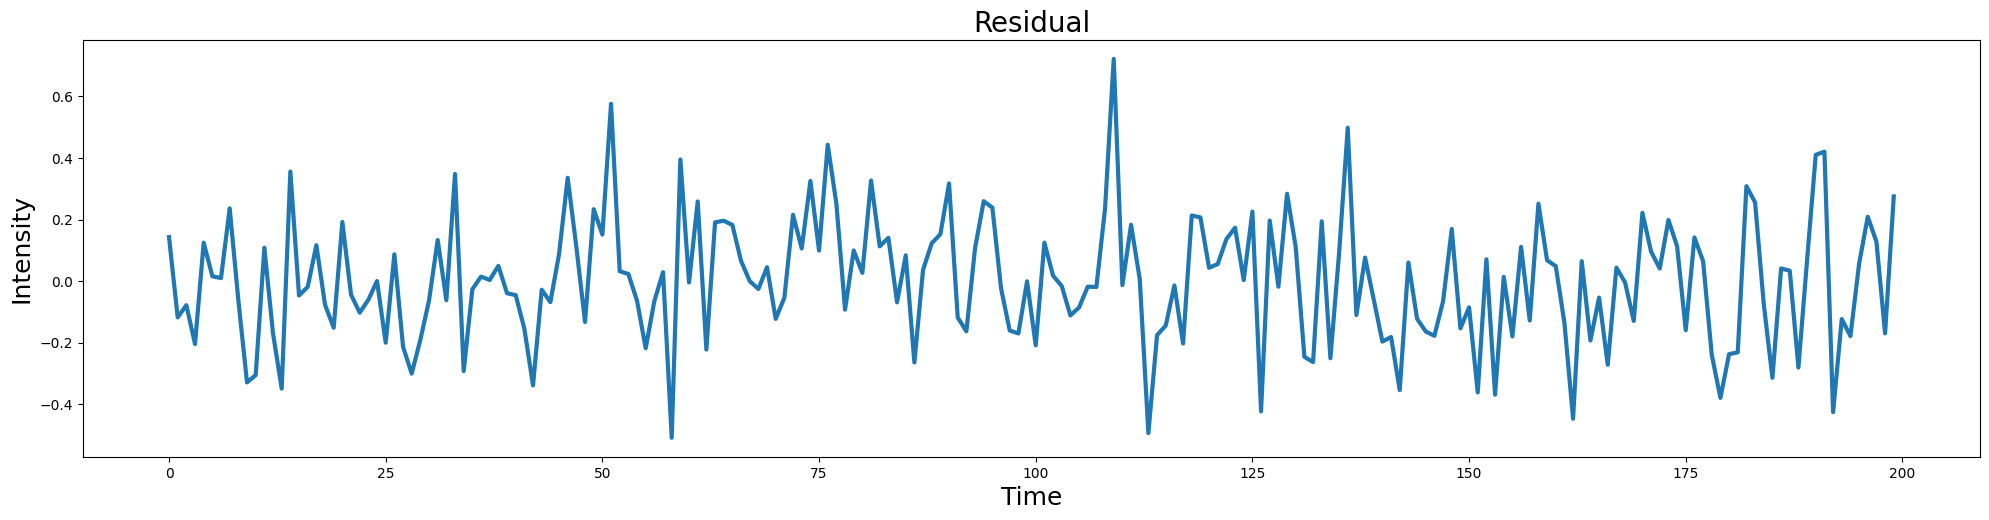

In [13]:
# 予実プロット
predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

residual = Y - predicted_y

plot_timeseries(residual)
plt.title('Residual', fontsize=20)

残差の分布を見てみる。
- 分布は正規分布っぽくなっていてほしい。
- 分散は小さいほうがモデルの当てはまりが良い。
  - $$\hat \sigma = \sqrt{\frac{\displaystyle \sum_i^n(\hat Y_i - Y_i)^2}{n-k}}$$

Standard Error of the Estimate: 0.2


Text(0.5, 0, 'Prediction Error')

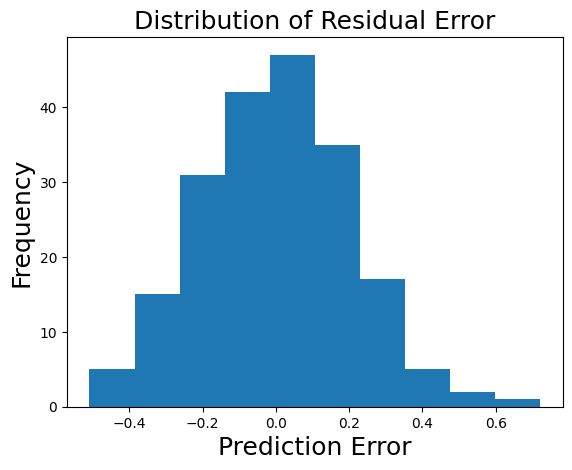

In [14]:
# 残差の分析
standard_error_of_estimate = np.std(residual)

print(f"Standard Error of the Estimate: {standard_error_of_estimate:.2}")

plt.hist(residual)
plt.title('Distribution of Residual Error', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Prediction Error', fontsize=18)

決定係数を計算してみる。
- 決定係数は、モデルの当てはまりの良さを表す指標。
  - データの分散をどれだけ説明できているかを表す。
  - 1に近いほど良い。

In [15]:
# 決定係数
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

print(f"R^2: {r_square(Y, predicted_y):.2}")

R^2: 0.65


推定量のばらつきを見てみる。
$$\sigma = \sqrt{diag((X^TX)^{-1})} \cdot \hat \sigma$$

Text(0, 0.5, 'Beta Value')

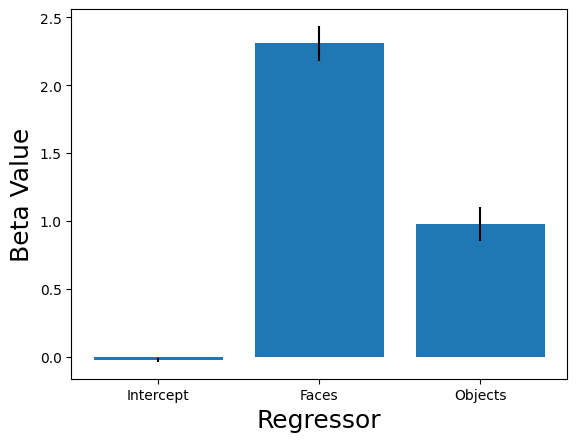

In [16]:
# 推定値プロットにエラーバーをつける（95％信頼区間）
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * standard_error_of_estimate

plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = std_error)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

統計的有意性を見てみる。
- 有意性は、t値で見る。
- $$t = \frac{\hat \beta_j}{\sigma_j}$$
  - 原文は、$\hat \sigma_j$としているが、コードと違うしこっちが正しいはず


In [17]:
t = beta/std_error
t

array([-1.44603331, 18.01104283,  7.62971777])

それぞれの推定量でt検定

[1.49740964e-01 1.16586526e-43 9.53479150e-13]


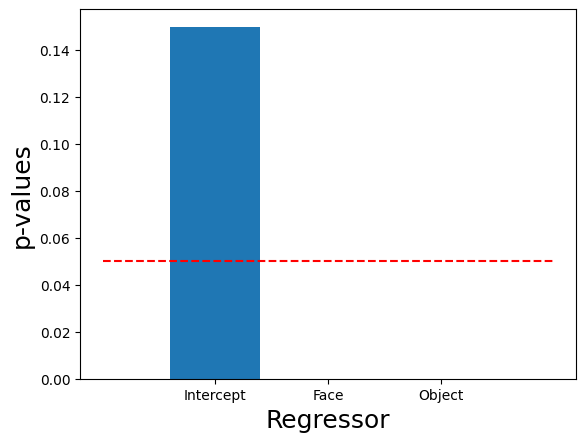

In [18]:
# 回帰係数の有意性検定
from scipy import stats

p = stats.t.sf(np.abs(t), n_tr-1)*2
print(p)

plt.bar(['Intercept', 'Face', 'Object'], p)
plt.ylabel('p-values', fontsize=18)
plt.xlabel('Regressor', fontsize=18)
plt.hlines(0.05, -1, 3, linestyles='dashed', color='red')

# コントラスト

コントラストは統計モデルにおける概念で、パラメータ（または変数）の特定の組み合わせを指す。具体的には、コントラストは実験条件間の比較を可能にするパラメータの組み合わせを示す

$$Y = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects$$

例えば、Facesの効果の大きさだけを見たい場合、コントラストは[0, 1, 0]となる（Facesのパラメータだけに焦点を当て、他のパラメータは無視する）。同様に、Objectsの効果の大きさだけを見たい場合、コントラストは[0, 0, 1]となる。

さらに、FacesとObjectsの間の差（つまり、顔を見ることと物体を見ることの脳の反応の違い）を評価したい場合、コントラストは[0, 1, -1]となる。これは、FacesのパラメータをObjectsのパラメータから引いた差を見ていることを意味する。

{('[0, 0, 1]', 0.9775241489651015),
 ('[0, 1, -1]', 1.330061772129405),
 ('[0, 1, 0]', 2.3075859210945064)}

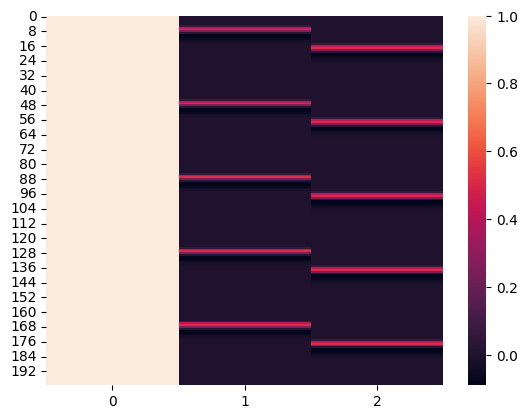

In [19]:
sns.heatmap(X)

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

{(str(c),np.dot(beta, c)) for c in [c1, c2, c3]}

効率性を見る
- 特定の実験環境における推定量の質を評価する指標

$$e(c\hat\beta) = \frac{1}{c(X^TX)^{-1}c^T}$$

In [20]:
def contrast_efficiency(X, contrast):
    c = np.array(contrast)
    return 1/(np.dot(np.dot(c, np.linalg.pinv(np.dot(X.T, X))), c.T))

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

[contrast_efficiency(X, x) for x in [c1, c2, c3]]

[2.5536839996192415, 2.5536839996192415, 1.3465769784519137]

ジッタリングによる試行内間隔の違い

- ジッタリング：刺激提示のタイミングをランダムに変動させることで、刺激間の時間的な相関をなくすこと
  - 被験者に予測させない
  - 時間的相関をなくす

[2.525502661014868, 2.431862877035974, 1.3760747711685348]

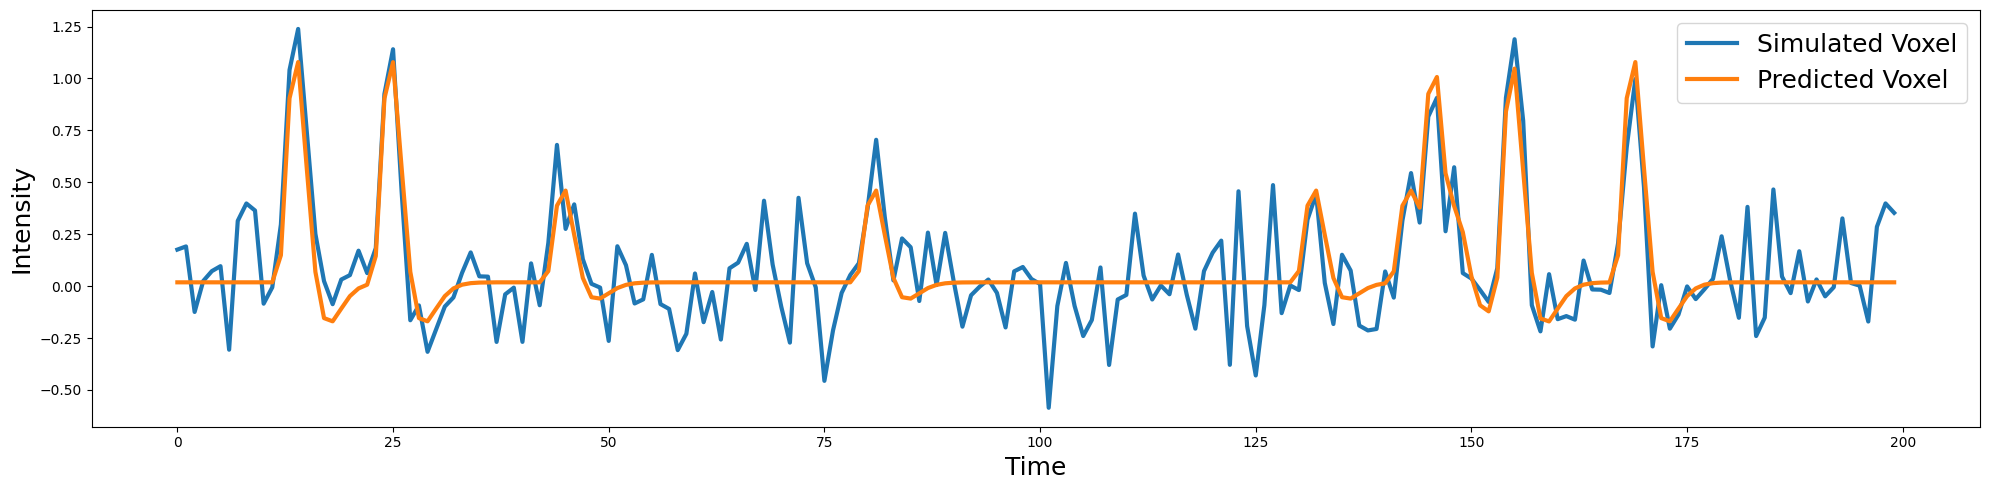

In [21]:
# Set Simulation Parameters
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1
sigma = 0.15

# Build Simulation
face_trials = np.random.randint(10, 180, n_trial)
obj_trials = np.random.randint(10, 180, n_trial)
face = np.zeros(n_tr)
face[face_trials] = 1
obj = np.zeros(n_tr)
obj[obj_trials] = 1
voxel_conv = np.vstack([np.convolve(face*face_intensity, hrf, mode='same'), np.convolve(obj*object_intensity, hrf, mode='same')]).T
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

# Build Model
Y = voxel_conv_noise.sum(axis=1)
X = np.vstack([np.ones(len(face)), np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

# Estimate Model
beta = ols_estimator(X, Y)
predicted_y = np.dot(X, beta)
predicted_sigma = np.std(residual)
predicted_ts = np.vstack([Y, predicted_y]).T
plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

# Estimate Contrast Efficiency
[contrast_efficiency(X, x) for x in [c1, c2, c3]]

自己相関
- fMRIデータの場合、TRの長さの自己相関がある。
- 対処する方法としては、多分TR期前の信号を回帰変数に入れてあげると言うこと
- 色々なライブラリがあって、やってくれる

# 練習問題

## 1. 信号の振幅が変わったらどうなる？

信号の強度（振幅）を3段階で変化させて、決定係数$r^2$がどう変化するかをプロットする。

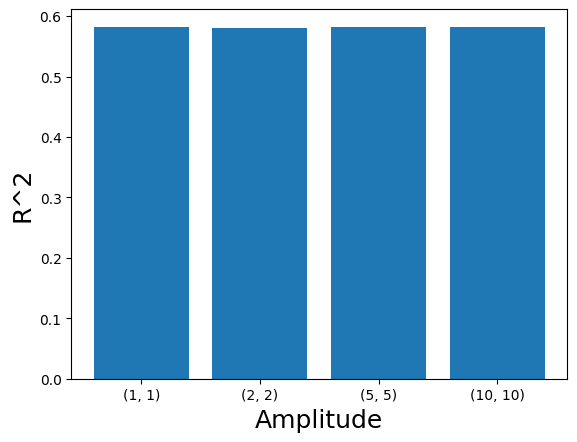

In [184]:
def change_amp(n_tr, n_trial, amp):
    
    r_square_list = []
    
    for i in amp:
        face_amp, obj_amp = i
    
        # because sigma changes every time, we need to average over multiple simulations
        
        result = []
        
        for j in range(7000):
            sigma = 0.15
            epsilon = sigma*np.random.randn(n_tr, 2)
            voxel_conv_noise = voxel_conv + epsilon
            Y = voxel_conv_noise.sum(axis=1)
            
            face = np.zeros(n_tr)
            face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_amp
            obj = np.zeros(n_tr)
            obj[np.arange(20, n_tr, int(n_tr/n_trial))] = obj_amp
            intercept = np.ones(n_tr)
            X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T
            
            beta = ols_estimator(X, Y)
            
            predicted_y = np.dot(X, beta)
            
            r_square_value = r_square(Y, predicted_y)
            
            result.append(r_square_value)
            
        # plt.hist(r_squared)
        r_square_list.append(np.mean(result))
        
    amp_str = [str(t) for t in amp]
    
    plt.bar(amp_str, r_square_list)
    plt.xlabel('Amplitude', fontsize=18)
    plt.ylabel('R^2', fontsize=18)


n_tr = 200
n_trial = 5

amp = [(1, 1), (2, 2), (5, 5), (10, 10)]

change_amp(n_tr, n_trial, amp)

A. 大して変わらない。

## 2. ノイズの振幅が変わったらどうなる？

ノイズの強度（振幅）を3段階で変化させて、決定係数$r^2$がどう変化するかをプロットする。

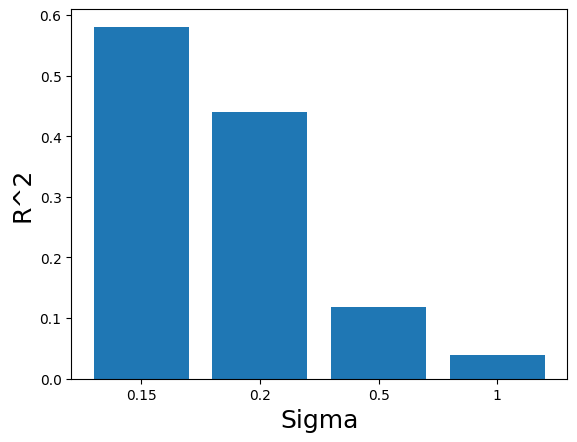

In [185]:
def change_noise(n_tr, n_trial, amp, sigmas):
    
    r_square_list = []
    
    face_amp, obj_amp = amp
    
    for sigma in sigmas:
    
        # because sigma changes every time, we need to average over multiple simulations
        
        result = []
        
        for j in range(7000):
            epsilon = sigma*np.random.randn(n_tr, 2)
            voxel_conv_noise = voxel_conv + epsilon
            Y = voxel_conv_noise.sum(axis=1)
            
            face = np.zeros(n_tr)
            face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_amp
            obj = np.zeros(n_tr)
            obj[np.arange(20, n_tr, int(n_tr/n_trial))] = obj_amp
            intercept = np.ones(n_tr)
            X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T
            
            beta = ols_estimator(X, Y)
            
            predicted_y = np.dot(X, beta)
            
            r_square_value = r_square(Y, predicted_y)
            
            result.append(r_square_value)
            
        # plt.hist(r_squared)
        r_square_list.append(np.mean(result))
        
    sigmas_str = [str(t) for t in sigmas]
    
    plt.bar(sigmas_str, r_square_list)
    plt.xlabel('Sigma', fontsize=18)
    plt.ylabel('R^2', fontsize=18)



n_tr = 200
n_trial = 5
amp = (1, 1)
sigmas = [0.15, 0.2, 0.5, 1]

change_noise(n_tr, n_trial, amp, sigmas)

A. ノイズは小さいほうが良い

## 3. トライアル回数はどれくらい必要？

トライアル回数を3段階で変化させて、コントラスト効率がどう変化するかをプロットする。

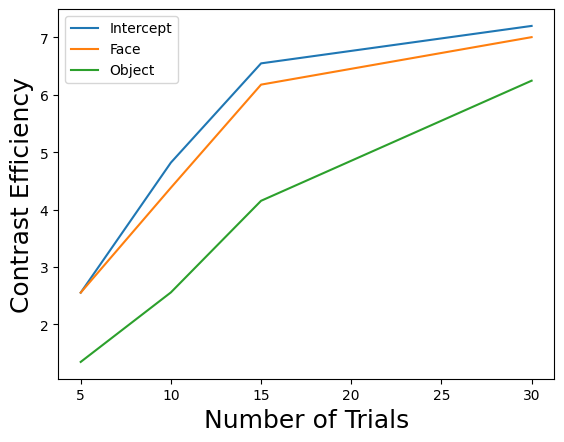

In [186]:
def change_trials(n_tr, n_trials, amp, sigma):
    
    face_amp, obj_amp = amp
    
    result = []
    
    for n_trial in n_trials:
        
        face = np.zeros(n_tr)
        face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_amp
        obj = np.zeros(n_tr)
        obj[np.arange(20, n_tr, int(n_tr/n_trial))] = obj_amp
        intercept = np.ones(n_tr)
        X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T
        
        c1 = [0, 1, 0]
        c2 = [0, 0, 1]
        c3 = [0, 1, -1]
        
        contrast_efficiency_value = [contrast_efficiency(X, x) for x in [c1, c2, c3]]
        
        result.append(contrast_efficiency_value)
    
    plt.plot(n_trials, result)
    plt.legend(['Intercept', 'Face', 'Object'])
    plt.ylabel('Contrast Efficiency', fontsize=18)
    plt.xlabel('Number of Trials', fontsize=18)

    


n_tr = 200
n_trials = [5, 10, 15, 30]
amp = (1, 1)
sigma = 0.15

change_trials(n_tr, n_trials, amp, sigma)

A. トライアル回数は多いほうが効率良い

## 4. 刺激の持続時間のインパクトは？

TRを変化させて、推定量$\beta$がどう変化するかをプロットする。

[[-0.00022007499444230417, -0.0010385641812307072, -0.0002748864185143327],
 [-0.00035909907290827093, 0.0016078936585507192, -0.0005920125718895911],
 [5.481737517608237e-05, -0.0005481602804214075, 0.00021257011407436837],
 [2.9657317603662846e-05, -0.0001596847260154059, 0.002252283328198452]]

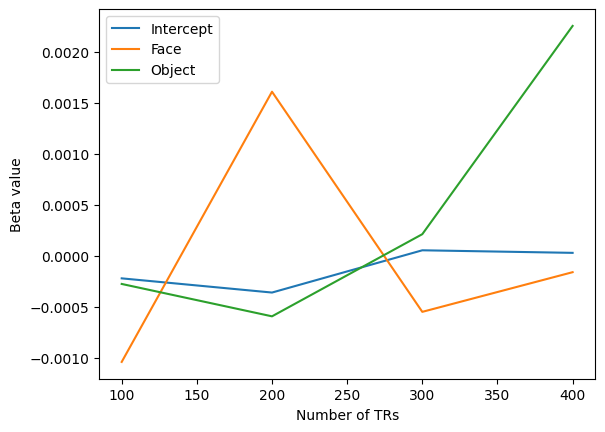

In [187]:
def change_ntr(n_trs, n_trial, amp, sigma):
    
    beta_list = []
    
    face_amp, obj_amp = amp
    
    for n_tr in n_trs:
    
        # because sigma changes every time, we need to average over multiple simulations
        
        result = []
        
        for j in range(7000):
            face = np.zeros(n_tr)
            obj = np.zeros(n_tr)
            hrf = glover_hrf(2, oversampling=1)

            face_conv = np.convolve(face, hrf, mode='same')
            obj_conv = np.convolve(obj, hrf, mode='same')
            voxel_conv = np.vstack([face_conv, obj_conv]).T
            
            epsilon = sigma*np.random.randn(n_tr, 2)
            voxel_conv_noise = voxel_conv + epsilon
            Y = voxel_conv_noise.sum(axis=1)
            
            face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_amp
            obj[np.arange(20, n_tr, int(n_tr/n_trial))] = obj_amp
            intercept = np.ones(n_tr)
            X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T
            
            beta = ols_estimator(X, Y)
            
            result.append(beta.tolist())
            
        # plt.hist(r_squared)
        beta_list.append(np.mean(result, axis=0).tolist())
            
    plt.plot(n_trs, beta_list)
    plt.legend(['Intercept', 'Face', 'Object'])
    plt.ylabel('Beta value')
    plt.xlabel('Number of TRs')
    
    return beta_list



n_trs = [100, 200, 300, 400]
n_trial = 5
amp = (1, 1)
sigmas = 0.15

change_ntr(n_trs, n_trial, amp, sigma)

A. TRが長いと、切片は0に近づいてそう。でもFacesとObjectsは正負が逆転してる？え？